# Artificial Neural networks

## The seasons of AI

The development of AI have always been met with hype cycles.
As seen with the McCulloch Pitts model, many foundations of "*AI*" have already been laid out in the 1940/1950s, but these constructs failed to meet their high expectations and promises, which finally lead to an abandonment of *AI* research, a circumstance labeled as an [AI Winter](https://en.wikipedia.org/wiki/AI_winter).

In the early 1980s, new architectures in neural networks and training methods re-initiated an interest in neural networks, but the the promised advancements were not met and by the 1990s other machine learning methods such as [Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine) were the focus of attention, which offered more reliable results in a more comprehensive theoretical framework, therefore the AI research went out of focus in the 90s.

The exact starting point of the current hype wave of AI or artifical neural networks is hard to pin down, but one crucial development were the results of [*AlexNet*](https://en.wikipedia.org/wiki/AlexNet) in 2012, which managed to get an increase in accuracy by 10% over the next entry, a rare circumstance which gets lots of attention. 
One thing that AlexNet taken advantage of was to use [*convolutions*](https://en.wikipedia.org/wiki/Kernel_(image_processing)) as a learnable part of a neural network architecture.
This architecture is inspired by the biological structure of the neurons within the visual cortex and was already proposed in the 1980s as [*Neocognitron*](https://en.wikipedia.org/wiki/Neocognitron).
But only due to the wide and cheap availability of GPUs through the gaming industry (which helped to reduce the time for the training procedure from months to days), as well as the availability of big datasets through the capturing measures of big data companies (which allowed to train a neural network with billions of parameters on a dataset of millions of pictures instead of thousands) allowed to re-visit the proposed architecture from the 1980s with big success.

The question of the current season of AI is therefore always apparent and unclear and is caused as well as a reason of the unpredictable nature of AIs topologies, which allows to enter the realm of dreams and desires of companies which try to construct new opportunities of profits, therefore the dreams of companies have to be realized by *"AI"*, and a failing of this does not result in a disadvantage for the dreamer but for the dream itself.

*AI* is therefore not a recent or new field of research, but had a coming and going which has been attached to the availability or lack of breakthroughs.

## How to program a neural network

While traditional programming uses algorithms to describe the output for a given input, programming neural networks involves more setting up an environment or topology with many degrees of freedom (*"variables"*) and a *traning* process, in which these degrees of freedom are tuned to a set of *samples* which traditionally contain a *sample* of the input data and an associated desired output.

There are lots of variations of how this topology or this training process can be constructed, and new paths in the structuring of these 

This setup still requires the use a combination of different crucial algorithms such as [AutoDiff](https://en.wikipedia.org/wiki/Automatic_differentiation) (an algorithm for automatic partial differentiation) or optimizing algorithms such as [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).
Instead of implementing those algorithms oneself, it is possible to use libraries which implement a variety of these algorithms and also have optimized versions for GPU available and there is a variety of libraries available these days.

This course will use *PyTorch* which provides a Python interface to all the necessary algorithms with a high level abstraction.

## Fully connected neural networks

A *fully connected neural network* is one of the basic architectures of neural networks.
It works by having multiple *layers* which each consist of multiple *neurons*.
Each neuron of a layer is connected to every neuron of its successive layer, therefore it is called a *fully connected* layer or neural network.
Each connection is modeled as a multiplication of the value with a *weight* of the connection.
All incoming connections of a neuron are then summed together, resulting in a new value which either acts as the output or act as intermediate value used as input for another layer (in which case the layer is called a hidden layer).

```{figure} https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg
:alt: An artifical neural network with 3 fully connected layers
:align: center

An artifical neural network with an input layer which consists of 3 input neurons, a hidden layer consisting of 4 neurons and an output layer with two neurons.
As all every neuron is *connected* with every neuron in the subsequent layer, this is called a *fully connected* network.
Note that the connections are also directed, so there is no way to introduce feedback loops - something which biological networks tend to form.
Source: <https://en.wikipedia.org/wiki/File:Colored_neural_network.svg>
```

## Implementation and iteration

### Simple FCNN

As a first introduction to neural networks, we will formulate, train, and evaluate a fully connected neural network that simply predicts the next note given the current note.
This is very similar to the Markov chain discussed earlier.

To implement such a network, we will use [Lightning](https://lightning.ai/docs/pytorch/stable/), which is build on top of [PyTorch](https://pytorch.org/).

In [ ]:
import lightning as L
import numpy as np
from pytorch_lightning.utilities.model_summary import summarize
from torch import Tensor, nn, optim, utils


class SimpleFCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 1 input neuron -> hidden layer w/ 4 neurons
            # we add a bias neuron to account for offsets
            nn.Linear(1, 4, bias=True),
            # relu layer as activation
            nn.ReLU(),
            # hidden layer w/ 4 neurons -> 1 output neuron
            nn.Linear(4, 1, bias=True),
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        # scalar value needs to be put into a vector
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        # z is the predicted note
        z = self.net(x)
        # print("x", x.shape, "y", y.shape, "z", z.shape)
        # we calculate the loss here
        loss = nn.functional.mse_loss(z, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.net(x.unsqueeze(1))
        test_loss = nn.functional.mse_loss(z, y.unsqueeze(1))
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


simple_fcnn = SimpleFCNN()

print(simple_fcnn)

print("Summary:")
summarize(simple_fcnn)

SimpleFCNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)
Summary:


  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 13     | train
--------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode

The summary above tells us that we have 13 parameters.

$$
\underbrace{((1+\underbrace{1}_{\text{bias}})*4)}_{\text{input -> hidden}} + \underbrace{((4+\underbrace{1}_{\text{bias}})*1)}_{\text{hidden -> output}} = 13
$$

There is also the question on how to evaluate the performance?
In the `training_step` method we refer to a *mse_loss* which stands for [*mean squared error*](https://en.wikipedia.org/wiki/Mean_squared_error), which is simply the average error squared (it is squared so a negative and positive error do not cancel out each other but do indeed accumulate), so

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( Y_i - \hat{Y_i}\ \right) ^2
$$

where $Y$ being the actual value and $\hat{Y}$ the predicted value.

Now it is time to actually load the data.

In [ ]:
import pandas as pd
from ki_ueben.datasets import Maestro3Dataset
from ki_ueben.midi import PianoRoll
from tqdm import tqdm

note_dfs = []
maestro_files = Maestro3Dataset()

# limit to first 100
for midi_path in tqdm(maestro_files[0:100]["file_path"]):
    piano_roll = PianoRoll(midi_path)
    df_events = piano_roll.events()
    # filter out pedal (note=-1) and note_off events (velocity=0)
    df_events = df_events[(df_events["note"] > 0) & (df_events["velocity"] > 0)]
    df_events["note"]
    note_dfs.append(df_events)

simple_df = pd.concat(note_dfs)
simple_df

100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


,note,velocity,time
1,77,56,0.994792
2,49,32,0.998698
4,73,58,1.108073
6,68,58,1.207031
8,73,62,1.315104
...,...,...,...
4811,69,60,216.302083
4812,78,70,216.867188
4816,79,68,217.937500
4818,71,57,217.954427


In [ ]:
import torch.utils
import torch.utils.data
from torch.utils.data.dataset import TensorDataset

# offset the data by 1 between X and y
simple_data_X = simple_df.iloc[:-1]["note"].to_numpy()
simple_data_y = simple_df.iloc[1:]["note"].to_numpy()

simple_dataset = TensorDataset(
    # convert midi note (int) to float as neural networks require floating
    # point numbers to calculate gradients, not discrete integers
    torch.from_numpy(simple_data_X).to(dtype=torch.float32),
    torch.from_numpy(simple_data_y).to(dtype=torch.float32),
)

In [ ]:
num_train_items = int(len(simple_dataset) * 0.8)
num_test_items = len(simple_dataset) - num_train_items

# split the dataset
simple_train, simple_test = torch.utils.data.random_split(
    dataset=simple_dataset,
    lengths=[num_train_items, num_test_items],
    # manual seeding so split is deterministic
    generator=torch.Generator().manual_seed(42),
)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    simple_train, batch_size=512, num_workers=4, persistent_workers=True
)
test_loader = DataLoader(simple_test, batch_size=512)

In [ ]:
from pytorch_lightning.loggers import CSVLogger

simple_trainer = L.Trainer(
    max_epochs=5, logger=[CSVLogger(save_dir="logs", name="simple_fcnn", version=0)]
)
simple_trainer.fit(model=simple_fcnn, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/simple_fcnn/simple_fcnn exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/simple_fcnn/simple_fcnn/checkpoints exists and is not empty.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 13     | train
--------------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 716/716 [00:06<00:00, 108.29it/s, v_num=fcnn, train_loss=249.0]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 716/716 [00:06<00:00, 108.14it/s, v_num=fcnn, train_loss=249.0]


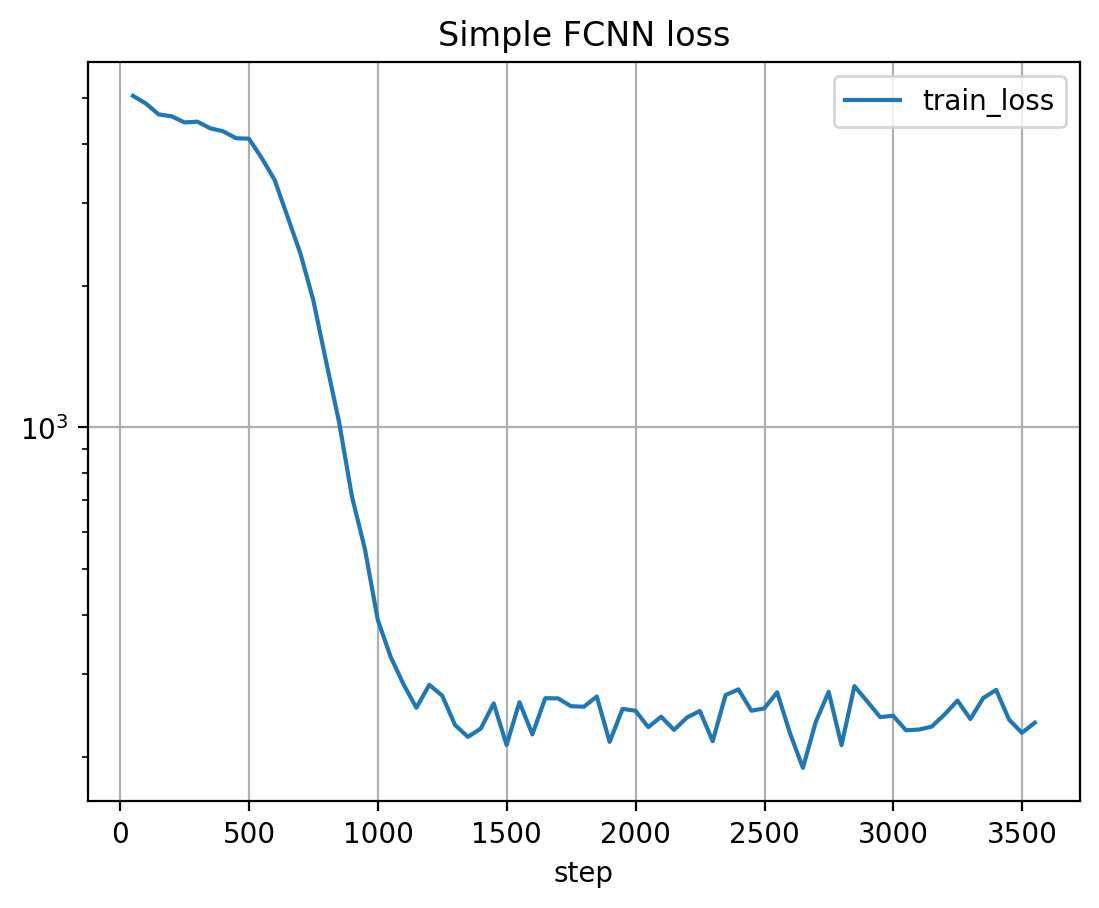

In [ ]:
df_simple_metrics = pd.read_csv("logs/simple_fcnn/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True, title="Simple FCNN loss", x="step", y="train_loss", logy=True
);

In [ ]:
simple_trainer.test(model=simple_fcnn, dataloaders=test_loader);

/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 179/179 [00:01<00:00, 105.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           244.32211303710938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
latest_note = 58

notes = []

for _ in range(10):
    notes.append(latest_note)
    latest_note = int(simple_fcnn.net(torch.Tensor([float(latest_note)]))[0])

print(notes)

[58, 56, 54, 53, 52, 51, 50, 49, 48, 47]


### Making the model more complex

We can also make the model a bit more complex, by adding an additional hidden layer and increase its dimensions.

In [ ]:
class AdvancedSimpleFCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 8, bias=True),
            nn.ReLU(),
            nn.Linear(8, 8, bias=True),
            nn.ReLU(),
            nn.Linear(8, 8, bias=True),
            nn.ReLU(),
            nn.Linear(8, 1, bias=True),
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        # scalar value needs to be put into a vector
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        # z is the predicted note
        z = self.net(x)
        # print("x", x.shape, "y", y.shape, "z", z.shape)
        # we calculate the loss here
        loss = nn.functional.mse_loss(z, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.net(x.unsqueeze(1))
        test_loss = nn.functional.mse_loss(z, y.unsqueeze(1))
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


advanced_simple_fcnn = AdvancedSimpleFCNN()

print(advanced_simple_fcnn)

print("Summary:")
summarize(advanced_simple_fcnn)

AdvancedSimpleFCNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)
Summary:


  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 169    | train
--------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode

In [ ]:
advanced_simple_trainer = L.Trainer(
    max_epochs=5,
    logger=[CSVLogger(save_dir="logs", name="advanced_simple_fcnn", version=0)],
)
advanced_simple_trainer.fit(model=advanced_simple_fcnn, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 169    | train
--------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 716/716 [00:06<00:00, 109.89it/s, v_num=0, train_loss=218.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 716/716 [00:06<00:00, 109.72it/s, v_num=0, train_loss=218.0]


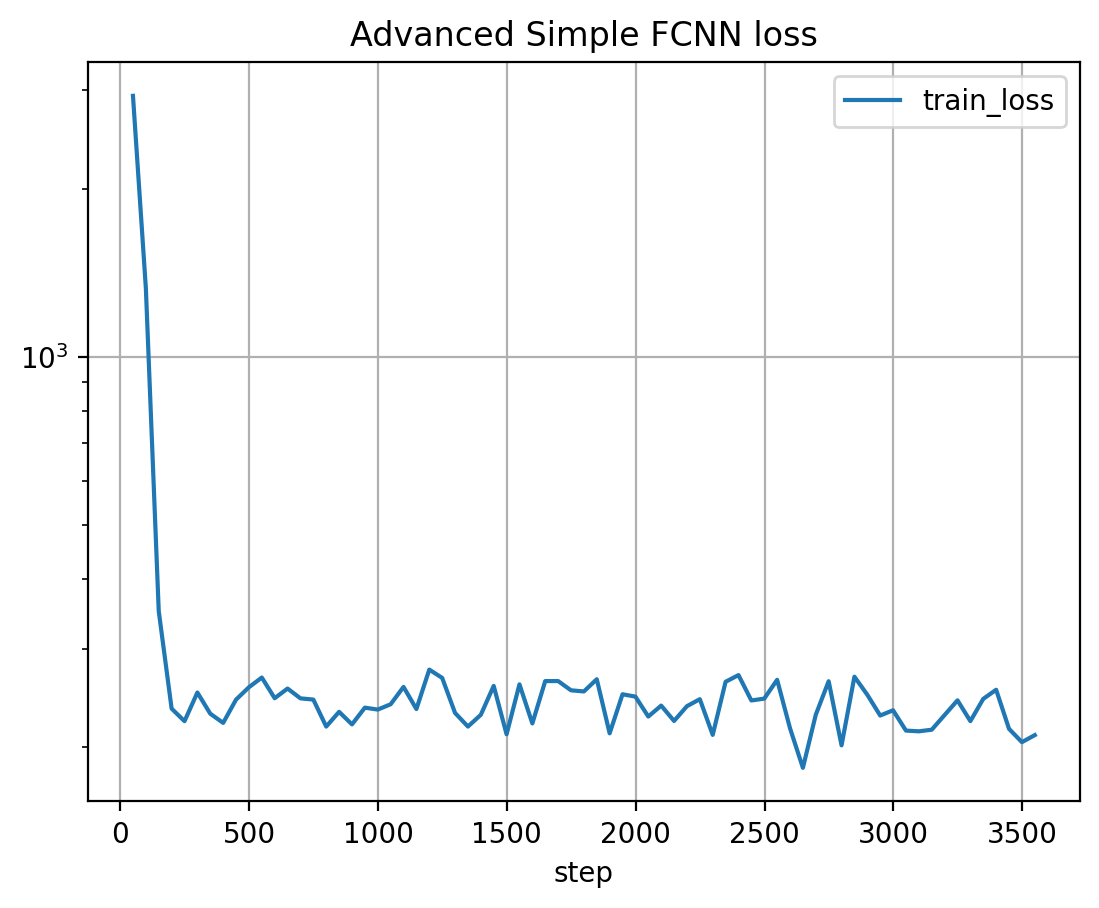

In [ ]:
metrics = pd.read_csv("logs/advanced_simple_fcnn/version_0/metrics.csv")
metrics.plot.line(
    grid=True, title="Advanced Simple FCNN loss", x="step", y="train_loss", logy=True
);

In [ ]:
advanced_simple_trainer.test(model=advanced_simple_fcnn, dataloaders=test_loader);

/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 179/179 [00:01<00:00, 109.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           215.78521728515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Adding context

Although it manages to perform a bit better, its loss is still immense.
One way to improve could be, instead of making the net bigger and bigger, provide some additional context, e.g. the latest 10 notes.

In [ ]:
class ContextFCNN(L.LightningModule):
    def __init__(self, num_notes: int = 10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_notes, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 1, bias=True),
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        # z is the predicted note
        z = self.net(x)
        # we calculate the loss here
        loss = nn.functional.mse_loss(z, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.net(x)
        test_loss = nn.functional.mse_loss(z, y)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


context_fcnn = ContextFCNN()

print(context_fcnn)

print("Summary:")
summarize(context_fcnn)

ContextFCNN(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
Summary:


  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 1.3 K  | train
--------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode

In [ ]:
maestro_files = Maestro3Dataset()

NUM_CONTEXT_INPUT = 10
NUM_CONTEXT_OUTPUT = 1

context_x = []
context_y = []

# limit to first 100
for midi_path in tqdm(maestro_files[0:100]["file_path"]):
    piano_roll = PianoRoll(midi_path)
    df_events = piano_roll.events()

    # filter out pedal (note=-1) and note_off events (velocity=0)
    df_events = df_events[(df_events["note"] > 0) & (df_events["velocity"] > 0)]

    for i in range(len(df_events) - NUM_CONTEXT_INPUT - NUM_CONTEXT_OUTPUT + 1):
        context_x.append(df_events.iloc[i : i + NUM_CONTEXT_INPUT]["note"].values)
        context_y.append(
            df_events.iloc[
                i + NUM_CONTEXT_INPUT : i + NUM_CONTEXT_INPUT + NUM_CONTEXT_OUTPUT
            ]["note"].values
        )

context_x = np.array(context_x)
context_y = np.array(context_y)

print(f"x: {context_x.shape} - y: {context_y.shape}")

100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


x: (457219, 10) - y: (457219, 1)


In [ ]:
context_dataset = TensorDataset(
    # convert midi note (int) to float as neural networks require floating
    # point numbers to calculate gradients, not discrete integers
    torch.from_numpy(context_x).to(dtype=torch.float32),
    torch.from_numpy(context_y).to(dtype=torch.float32),
)

In [ ]:
num_train_items = int(len(context_dataset) * 0.8)
num_test_items = len(context_dataset) - num_train_items

# split the dataset
context_train, context_test = torch.utils.data.random_split(
    dataset=context_dataset,
    lengths=[num_train_items, num_test_items],
    # manual seeding so split is deterministic
    generator=torch.Generator().manual_seed(42),
)

In [ ]:
context_train_loader = DataLoader(
    context_train, batch_size=512, num_workers=4, persistent_workers=True
)
context_test_loader = DataLoader(context_test, batch_size=512)

In [ ]:
context_trainer = L.Trainer(
    max_epochs=15, logger=[CSVLogger(save_dir="logs", name="context_fcnn", version=0)]
)
context_trainer.fit(model=context_fcnn, train_dataloaders=context_train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 1.3 K  | train
--------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 715/715 [00:06<00:00, 107.10it/s, v_num=0, train_loss=143.0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 715/715 [00:06<00:00, 106.94it/s, v_num=0, train_loss=143.0]


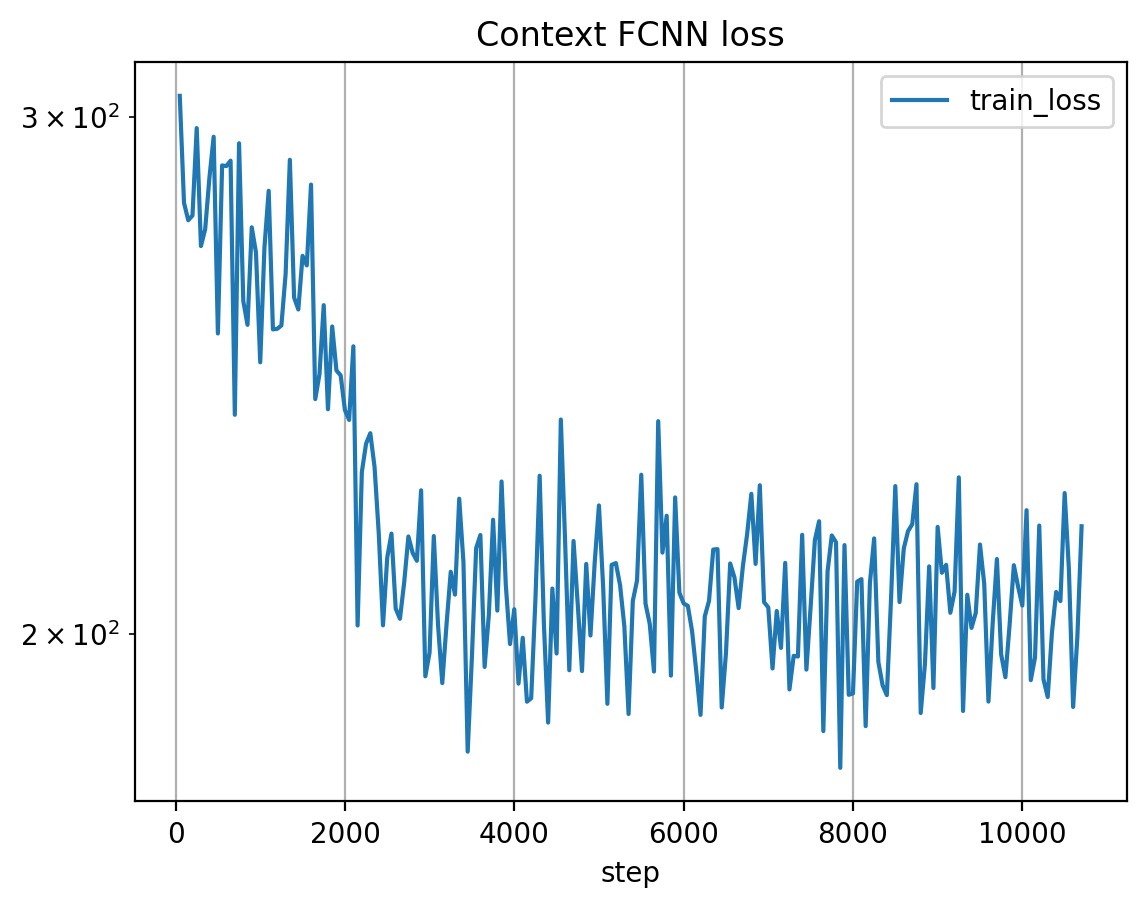

In [ ]:
metrics = pd.read_csv("logs/context_fcnn/version_0/metrics.csv")
metrics.plot.line(
    grid=True, title="Context FCNN loss", x="step", y="train_loss", logy=True
);

In [ ]:
context_trainer.test(model=context_fcnn, dataloaders=context_test_loader);

/Users/scheiba/github/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 179/179 [00:01<00:00, 113.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           141.39073181152344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
len(note_sequence[0:10])

10

In [ ]:
note_sequence = [60, 58, 60, 59, 30, 60, 64, 65, 59, 60]

notes = []

for i in range(10):
    latest_note = int(
        context_fcnn.net(
            torch.Tensor(note_sequence[i : i + 10]).to(dtype=torch.float32)
        )
    )
    note_sequence.append(latest_note)

print(note_sequence)

[60, 58, 60, 59, 30, 60, 64, 65, 59, 60, 57, 58, 58, 58, 59, 60, 59, 59, 59, 59]
